#Installing Dependencies

In [ ]:
!pip install python-dotenv
!pip install beautifulsoup4
!pip install langchain
!pip install langchain-community
!pip install faiss-cpu  # Or faiss-gpu if you have a GPU
!pip install langchain-core
!pip install langchain-groq
!pip install huggingface_hub
!pip install langchain-community[embeddings]




In [20]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00


#Set Environment Vars and API Keys

In [11]:
from dotenv import load_dotenv , find_dotenv
load_dotenv(find_dotenv())

True

In [13]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_PROJECT'] = 'advanced-rag'
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
os.environ['GROQ_API_KEY'] = os.getenv("GROQQ_API_KEY")

#OVERVIEW

Step 1: Fetch and prepare webpage content.


Step 2: Break it into chunks and convert text into embeddings (vectors).


Step 3: Store embeddings in FAISS for efficient search.


Step 4: Retrieve relevant parts based on a question.


Step 5: AI generates an answer using a structured prompt.


Step 6: The final answer is returned to the user.

In [17]:
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_groq import ChatGroq
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

#### INDEXING ####

# Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
##1 - 0 - 1000 , 800 - 1800

# Split - Chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Embed
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)
vectorstore = FAISS.from_documents(documents=splits,
                                    embedding=hf_embeddings)

retriever = vectorstore.as_retriever() # Dense Retrieval - Embeddings/Context based

#### RETRIEVAL and GENERATION ####

# Prompt
prompt = hub.pull("rlm/rag-prompt") #converting into a standard prompt format

# LLM
llm = ChatGroq(model="llama3-8b-8192", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
print(rag_chain.invoke("What is Task Decomposition?"))

Task Decomposition is a process that breaks down a complicated task into smaller and simpler steps, allowing an agent to plan ahead and utilize more test-time computation. This is achieved through techniques such as Chain of Thought (CoT) and Tree of Thoughts (Yao et al. 2023), which transform big tasks into multiple manageable tasks and provide an interpretation of the model's thinking process.


{ "key1": component1 | component2, "key2": component3 }  # Dictionary transformation
| prompt  # Apply a prompt template
| llm  # Generate a response using an AI model
| output_parser  # Convert the output into plain text

retriever-> finds the most semantically similar chunk from the vector db

format_docs->converts the retrieved chunk into plain text

the plain text forms the context, and then we have the question

the {context:"____",question:"____"} both form a dictionary which is then apssed into the prompt structure

this prompt passes into the llm

the output converted into plain text by StrOutputParser()

# FIXING ENVIRONMENT VARIABLES AND API Keys

In [9]:
# import os

# env_path = "/content/.env"
# if os.path.exists(env_path):
#     os.remove(env_path)
#     print(".env file deleted.")
# else:
#     print(".env file not found.")


.env file deleted.


In [29]:
#find_dotenv()

'/content/.env'

In [8]:
# import os
# print(os.getenv("LANGCHAIN_API_KEY"))  # Should print the key
# print(os.getenv("GROQ_API_KEY"))  # Should print the key


None
None


In [7]:
# import os

# # List of environment variables to remove
# env_vars = ["LANGCHAIN_API_KEY", "GROQ_API_KEY"]

# # Delete each environment variable
# for var in env_vars:
#     if var in os.environ:
#         del os.environ[var]

# print("All specified environment variables have been deleted.")


All specified environment variables have been deleted.


In [ ]:
# import os
# os.kill(os.getpid(), 9)


# INDEXING

In [42]:
# Documents
question = "cat"
document = "dog"

In [18]:
# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

In [21]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

In [43]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)
query_result = hf_embeddings.embed_query(question)
document_result = hf_embeddings.embed_query(document)
len(query_result)

384

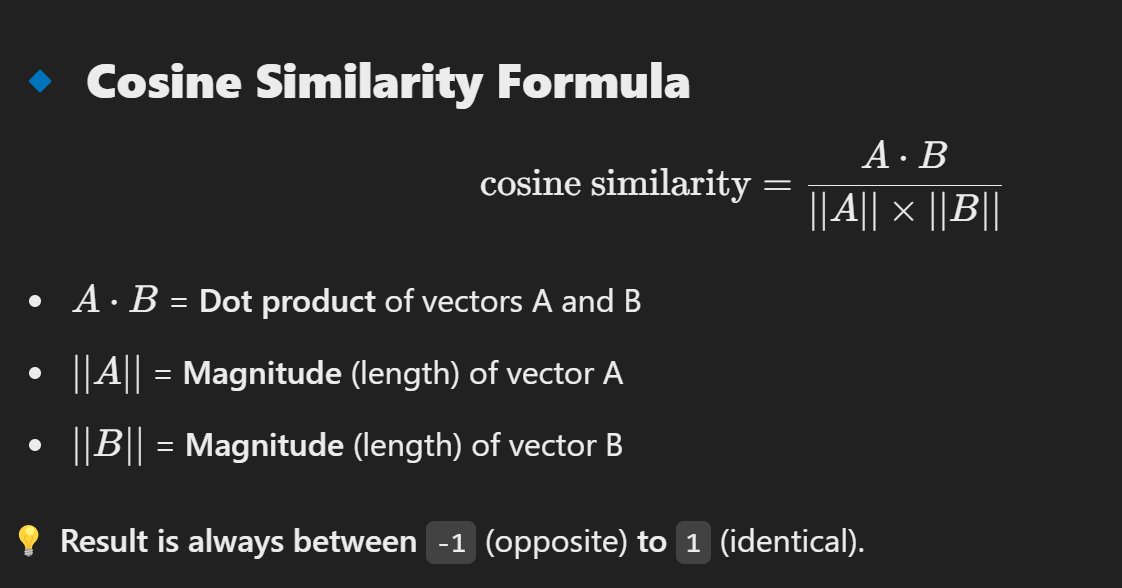

In [44]:
import numpy as np

def cosine_similarity(query_vec,doc_vec):
  dot_product = np.dot(query_vec, doc_vec)
  query_norm = np.linalg.norm(query_vec)
  doc_norm = np.linalg.norm(doc_vec)
  return dot_product / (query_norm * doc_norm)

In [45]:
cosine_similarity(query_result,document_result)

0.9187177271046878

In [46]:
# Index- vectorstore
from langchain_community.vectorstores import FAISS
vectorstore = FAISS.from_documents(documents=splits,
                                    embedding=hf_embeddings)

retriever = vectorstore.as_retriever()

In [47]:
retriever

VectorStoreRetriever(tags=['FAISS', 'HuggingFaceBgeEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7b24a6c07610>, search_kwargs={})

#RETRIEVAL

In [49]:
docs = retriever.get_relevant_documents("What is Task Decomposition?")
len(docs)

4

In [50]:
docs[0]

Document(id='ad9f7643-d5f3-451a-a044-9deb0de10a42', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The searc

#GENERATION

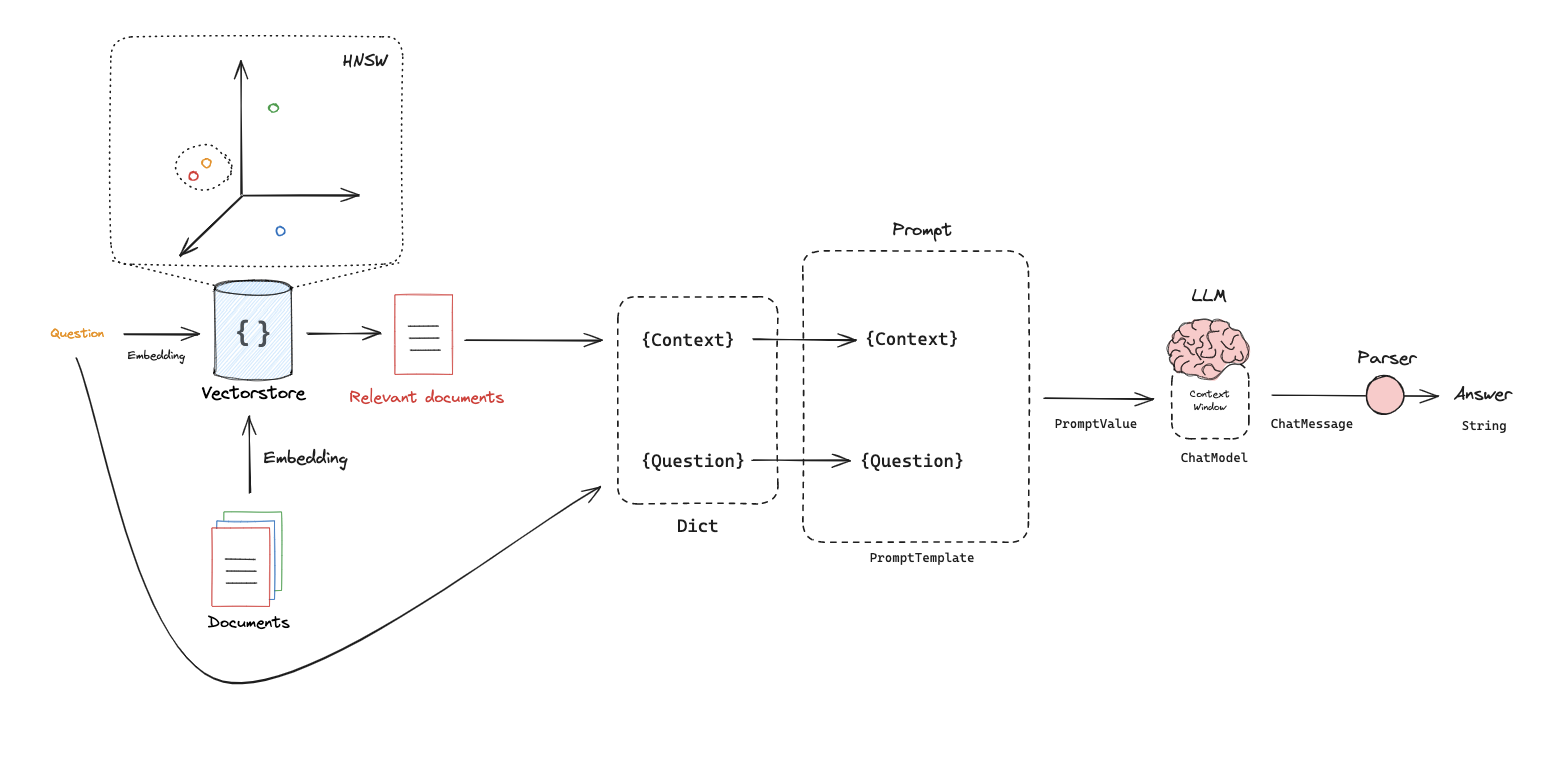

In [52]:
# Prompt
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n{context}\n\nQuestion: {question}\n'), additional_kwargs={})])

In [53]:
# LLM
llm = ChatGroq(model="llama3-8b-8192", temperature=0)

In [54]:
# Chain
chain = prompt | llm

In [57]:
# Run
chain.invoke({"context":docs,"question":"What is Task Decomposition?"})

AIMessage(content='According to the provided context, Task Decomposition is a process where an agent breaks down a complicated task into smaller and simpler steps. This can be done using various techniques, such as:\n\n1. Chain of Thought (CoT): instructing the model to "think step by step" to decompose hard tasks into smaller steps.\n2. Tree of Thoughts (Yao et al. 2023): decomposing the problem into multiple thought steps and generating multiple thoughts per step, creating a tree structure.\n3. Simple prompting: using LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", or using task-specific instructions.\n\nTask decomposition can be used to transform big tasks into multiple manageable tasks, allowing the agent to plan ahead and make more informed decisions.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 164, 'prompt_tokens': 1096, 'total_tokens': 1260, 'completion_time': 0.136666667, 'prompt_time': 0.1382

In [58]:
from langchain import hub
prompt_hub_rag = hub.pull("rlm/rag-prompt")

In [59]:
prompt_hub_rag

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [63]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt_hub_rag
    | llm
    #| StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

AIMessage(content='Task Decomposition is the process of breaking down a complex task into smaller, simpler steps. This can be done through techniques such as Chain of Thought or Tree of Thoughts, or by using simple prompting like "Steps for XYZ" or task-specific instructions.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 1142, 'total_tokens': 1193, 'completion_time': 0.0425, 'prompt_time': 0.153672032, 'queue_time': 0.020798852000000007, 'total_time': 0.196172032}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run-91ded093-ccfe-4ce5-ad03-c4b7a711c3c4-0', usage_metadata={'input_tokens': 1142, 'output_tokens': 51, 'total_tokens': 1193})

In [64]:
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt_hub_rag
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

'Task Decomposition is the process of breaking down a complex task into smaller, simpler steps. This can be done through techniques such as Chain of Thought or Tree of Thoughts, or by using simple prompting like "Steps for XYZ" or task-specific instructions.'